In [1]:
from collections import OrderedDict
import os
import sys
import warnings

import argparse
import logging
import h5py as h5f
import numpy as np
import pandas as pd
import scipy.io

import six
from six.moves import range
import matplotlib.pyplot as plt
#from dna import *
import tensorflow as tf
from sklearn.metrics import roc_auc_score, confusion_matrix
from keras.preprocessing import sequence
from keras.optimizers import RMSprop,Adam, SGD
from keras.models import Sequential, Model
from keras.layers.core import  Dropout, Activation, Flatten
from keras.regularizers import l1,l2,l1_l2
from keras.constraints import maxnorm
#from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, Bidirectional, BatchNormalization, MaxPooling2D, AveragePooling1D, Input, Multiply, Add, UpSampling1D,Concatenate
from sklearn.metrics import mean_squared_error as mse
import scipy.stats as st
#from keras.utils import plot_model
#from keras.utils.layer_utils import print_layer_shapes
# fix random seed for reproducibility

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from random import shuffle
from sklearn.utils import shuffle
np.random.seed(1369)

In [2]:
from lime import lime_tabular

In [3]:
def PREPROCESS(lines):    
    data_n = len(lines)
    SEQ = np.zeros((data_n, 28, 4), dtype=int)
    Score = np.zeros((data_n, 1), dtype=float)
    for l in range(0, data_n):
        seq = lines[l]
        for i in range(28):
            if seq[i] in "Aa":
                SEQ[l, i, 0] = 1
            elif seq[i] in "Cc":
                SEQ[l, i, 1] = 1
            elif seq[i] in "Gg":
                SEQ[l, i, 2] = 1
            elif seq[i] in "Tt":
                SEQ[l, i, 3] = 1
        #CA[l-1,0] = int(data[2])*100
	
    return SEQ

In [4]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [5]:
def countGC(seq):
    '''
    GC content for only the 20mer, as per the Doench paper/code
    '''
    return len( seq[3:23].replace( 'A', '' ).replace( 'T', '' ) )

In [6]:
def gc_cont(seq):
    return (seq.count( 'G' ) + seq.count( 'C' )) / float( len( seq ) )

In [7]:
df = pd.read_csv('kmarc_medium_cs.csv')
df.shape

(478786, 7)

In [8]:
df['Temperature'] = df.Temperature.astype('category')
df['Medium'] = df.Medium.astype('category')

In [9]:
df.dtypes

Guide No.             float64
location of crRNA      object
20bp_crRNA             object
28bp_crRNA             object
Cutting_score         float64
Temperature          category
Medium               category
dtype: object

In [10]:
col_list = ['Temperature','Medium']
df_enc = one_hot(df,col_list)

In [11]:
df_enc = shuffle(df_enc)

In [12]:
guide_seq = df_enc['28bp_crRNA'].to_list()

In [13]:
med = df_enc.loc[:,['Medium_glucose', 'Medium_lactose','Medium_xylose']]
temp = df_enc.loc[:,['Temperature_30', 'Temperature_37']]

In [14]:
med_arr = med.values
temp_arr = temp.values

In [15]:
med_temp_arr = np.concatenate((med_arr,temp_arr), axis =1)
med_temp_arr.shape

(478786, 5)

In [16]:
guide_seq = df_enc['28bp_crRNA'].to_list()

In [17]:
len(guide_seq)

478786

In [18]:
SEQ = PREPROCESS(guide_seq)

In [19]:
score = df_enc.loc[:,'Cutting_score']
score = score.values

In [20]:
X_seq = SEQ
X_mt = med_temp_arr
y = score  

In [21]:
X_mt.shape

(478786, 5)

In [22]:
X_seq.shape

(478786, 28, 4)

In [23]:
train_size = int(X_seq.shape[0] * 0.6)
val_size = train_size +int(X_seq.shape[0] * 0.2)

In [24]:
X_seq_f = X_seq.reshape(X_seq.shape[0],-1)

In [25]:
X_seq_f.shape

(478786, 112)

In [26]:
X_seq_ff = np.expand_dims(X_seq_f, axis=1)
X_seq_ff.shape

(478786, 1, 112)

In [27]:
X_mt_f = np.expand_dims(X_mt, axis =1)
X_mt_f.shape

(478786, 1, 5)

In [ ]:
#X = np.concatenate((X_seq_ff, X_mt_f), axis=2)
#X.shape

In [28]:
X = X_seq_ff

In [ ]:
pos_features = []
for pos in range(0,28):
    pos_features.append(str(pos)+'_'+'a')
    pos_features.append(str(pos)+'_'+'c')
    pos_features.append(str(pos)+'_'+'g')
    pos_features.append(str(pos)+'_'+'t')

In [ ]:
pos_features[0:10]

In [ ]:
len(pos_features)

In [ ]:
mt_featutes =['temp_0','temp_1','med_0','med_1','med_2']

In [ ]:
pos_mt_features = pos_features + mt_featutes

In [ ]:
len(pos_mt_features)

In [ ]:
pos_mt_features[-5:]

In [29]:
X_train = X[0:train_size]
X_val = X[train_size:val_size]
X_test = X[val_size:]

In [30]:
y_train = y[0:train_size]
y_val = y[train_size:val_size]
y_test = y[val_size:]

In [31]:
SEQ = Input(shape=(1,112))
blstm_1 = Bidirectional(LSTM(units=16, dropout=0.0,recurrent_dropout=0.0, return_sequences=True))(SEQ)
blstm_2 = Bidirectional(LSTM(units=8,dropout=0.0, return_sequences=True))(blstm_1)
flatten = Flatten()(blstm_2)
dropout_1 = Dropout(0.5)(flatten)
dense_1 = Dense(80, activation='relu', kernel_initializer='glorot_uniform')(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)
dense_2 = Dense(units=40,  activation="relu",kernel_initializer='glorot_uniform')(dropout_2)
dropout_3 = Dropout(0.3)(dense_2)
dense_3 = Dense(units=40,  activation="relu",kernel_initializer='glorot_uniform')(dropout_3)
out = Dense(units=1,  activation="linear")(dense_3)
model = Model(inputs = SEQ, outputs= out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 112)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 32)             16512     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 16)             2624      
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 80)                1360      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0     

In [32]:
adam = Adam(lr = 0.001)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="seq_cs_lstm.hdf5",verbose=1, monitor='val_loss',save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
# add tensorboard
tf_callbacks = tf.keras.callbacks.TensorBoard(log_dir = "logs/fit" , histogram_freq = 1)
history = model.fit([X_train], y_train, batch_size=64, epochs=50, shuffle=True, validation_data=( [X_val], y_val), callbacks=[checkpointer,earlystopper,tf_callbacks])

Epoch 1/50
4484/4489 [============================>.] - ETA: 0s - loss: 5.7187
Epoch 00001: val_loss improved from inf to 5.07185, saving model to seq_cs_lstm.hdf5
4489/4489 [==============================] - 25s 6ms/step - loss: 5.7183 - val_loss: 5.0719
Epoch 2/50
4488/4489 [============================>.] - ETA: 0s - loss: 4.9878
Epoch 00002: val_loss improved from 5.07185 to 4.77263, saving model to seq_cs_lstm.hdf5
4489/4489 [==============================] - 24s 5ms/step - loss: 4.9877 - val_loss: 4.7726
Epoch 3/50
4486/4489 [============================>.] - ETA: 0s - loss: 4.6854
Epoch 00003: val_loss improved from 4.77263 to 4.62455, saving model to seq_cs_lstm.hdf5
4489/4489 [==============================] - 24s 5ms/step - loss: 4.6854 - val_loss: 4.6245
Epoch 4/50
4483/4489 [============================>.] - ETA: 0s - loss: 4.4597
Epoch 00004: val_loss improved from 4.62455 to 4.45252, saving model to seq_cs_lstm.hdf5
4489/4489 [==============================] - 24s 5ms/ste

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

In [ ]:
explainer = lime_tabular.RecurrentTabularExplainer(X_train, training_labels=y_train, feature_names=pos_mt_features,
                                                   discretize_continuous = False,
                                                   mode = 'regression')

In [ ]:
exp = explainer.explain_instance(X_test[45], 
     model.predict, num_features=10)
exp.as_pyplot_figure()

In [ ]:
y_test[0:10]

In [ ]:
max(y_test)

In [ ]:
min(y_test)

In [ ]:
X_test.shape

In [ ]:
aa = np.argsort(y_test)

In [ ]:
aa[0:5]

In [ ]:
aa[-5:]

In [ ]:
y_test[6897]

In [ ]:
y_test[95381]

In [ ]:
y_test[12300]

In [ ]:
y_test[79840]

testset
mse 3.5700616156899785
SpearmanrResult(correlation=0.7129045582101791, pvalue=0.0)
SpearmanrResult(correlation=0.7262174091589781, pvalue=0.0)


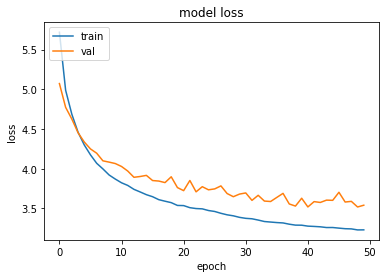

In [33]:
print('testset')
pred_y = model.predict([X_test ])
print('mse ' + str(mse(y_test, pred_y)))
print(st.spearmanr(y_test, pred_y))
y_pred_tr = model.predict([X_train])
print(st.spearmanr(y_train, y_pred_tr)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show() 

In [34]:
pred_y = pred_y.flatten()
y_test = y_test.flatten()
print(st.pearsonr(y_test, pred_y))

(0.7809944820519232, 0.0)


In [ ]:
exp = explainer.explain_instance(X_test[12300], 
     model.predict, num_features=10)
exp.as_pyplot_figure()

In [ ]:
exp = explainer.explain_instance(X_test[52753], 
     model.predict, num_features=10)
exp.as_pyplot_figure()

In [ ]:
ind = 79840
exp = explainer.explain_instance(X_test[ind], 
     model.predict, num_features=10)
exp.as_pyplot_figure()

In [ ]:
ind = 29400
exp = explainer.explain_instance(X_test[ind], 
     model.predict, num_features=10)
exp.as_pyplot_figure()

In [ ]:
ind = 5832
exp = explainer.explain_instance(X_test[ind], 
     model.predict, num_features=10)
exp.as_pyplot_figure()